🔹You can skip the first 6 cells and start from the importing cell (cell 7) if you use kaggle but if you use colab these cells are must to download the dataset

🔹 Cell 1: Uploading Files in Colab

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beshoyhakeem","key":"a6a2a07c95e6f6673c6f1551739a7e66"}'}

🔹 Cell 2 & 3: Preparing Kaggle API

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!mv kaggle.json ~/.kaggle/

🔹 Cell 4: Securing Your Kaggle API Token

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

🔹 Cell 5: Downloading Dataset from Kaggle

In [5]:
!kaggle datasets download shanegerami/ai-vs-human-text

Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other


🔹 Cell 6: Extracting the Dataset

In [6]:
!unzip ai-vs-human-text -d dataset/

Archive:  ai-vs-human-text.zip
  inflating: dataset/AI_Human.csv    


🔹 Cell 7: Importing Required Libraries

In [14]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm  # For progress bars

🔹 Cell 8: Text Preprocessing and Dataset Loading

In [ ]:
# Download NLTK resources
nltk.download('punkt')

def clean_text_simple(text):
    """
    Enhanced text cleaning for BERT input:
    1. Remove URLs
    2. Remove special chars/punctuation (keeping basic sentence structure)
    3. Clean whitespace
    4. Preserve case (BERT is case-sensitive)
    """
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters except basic punctuation
    text = re.sub(r'[^\w\s.,!?]', '', text)

    # Clean whitespace
    text = ' '.join(text.split())

    return text

#  Load and prepare larger dataset
data = pd.read_csv('/content/dataset/AI_Human.csv')
# Verify columns
print("Original columns:", data.columns.tolist())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original columns: ['text', 'generated']


🔹 Cell 9: Balancing the Dataset

In [11]:
# Create larger balanced subset (50k from each class)
human_data = data[data['generated'] == 0].sample(50000, random_state=42)
ai_data = data[data['generated'] == 1].sample(50000, random_state=42)
balanced_data = pd.concat([human_data, ai_data]).sample(frac=1, random_state=42)

# Clean text
balanced_data['cleaned_text'] = balanced_data['text'].apply(clean_text_simple)


🔹 Cell 10: Splitting into Train/Test Sets

In [12]:
# 2. Prepare datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['cleaned_text'],
    balanced_data['generated'],
    test_size=0.2,
    random_state=42
)

🔹 Cell 11: Batch Tokenization with Progress Tracking

In this step, we perform batch tokenization of the text data using the BERT tokenizer. This process involves converting text into a format that can be fed into a BERT model for training and evaluation. The tokenization is done in batches to efficiently handle large datasets, and progress is tracked using a progress bar.

In [15]:
# 3. Batch Tokenization with Progress Tracking
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def batch_tokenize(texts, labels, tokenizer, batch_size=512, max_length=256):
    """
    Tokenize texts in batches with progress tracking
    Args:
        texts: List or Series of texts to tokenize
        labels: Corresponding labels
        tokenizer: Pre-trained tokenizer
        batch_size: Number of texts per batch
        max_length: Maximum sequence length
    Returns:
        Dictionary containing tokenized inputs and labels
    """
    # Convert to lists if Pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    if isinstance(labels, pd.Series):
        labels = labels.tolist()

    input_ids = []
    attention_masks = []
    all_labels = []

    # Process in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch_texts = texts[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Tokenize the batch
        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])
        all_labels.extend(batch_labels)

    return {
        'input_ids': torch.cat(input_ids),
        'attention_mask': torch.cat(attention_masks),
        'labels': torch.tensor(all_labels, dtype=torch.long)
    }

# Tokenize datasets
print("\nTokenizing training set...")
train_encodings = batch_tokenize(train_texts, train_labels, tokenizer)

print("\nTokenizing test set...")
test_encodings = batch_tokenize(test_texts, test_labels, tokenizer)


Tokenizing training set...


Tokenizing: 100%|██████████| 157/157 [08:48<00:00,  3.36s/it]



Tokenizing test set...


Tokenizing: 100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


🔹 Cell 12: Dataset Class

In this step, we define a custom dataset class to handle the tokenized data, making it compatible with PyTorch's data handling utilities. This class will facilitate the efficient loading and batching of data during model training and evaluation.

In [ ]:
#  Dataset Class
class AITextDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = encodings['labels']

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = AITextDataset(train_encodings)
test_dataset = AITextDataset(test_encodings)

🔹 Cell 13: GPU Setup and Model Initialization

In this step, we set up the computational device and initialize the BERT model for sequence classification. This setup is crucial for leveraging hardware acceleration and preparing the model for training.

In [ ]:
#  GPU setup and model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)


Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔹 Cell 14: Training Configuration Optimized for GPU

In this step, we configure the training parameters for the BERT model, optimizing for GPU usage to enhance performance and efficiency during training.

In [ ]:
#  Training configuration optimized for GPU
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,  # Larger batches on GPU
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    gradient_accumulation_steps=1,  # No need for accumulation with larger GPU batches
    fp16=True,  # Mixed precision training
    dataloader_drop_last=True,
    optim="adamw_torch",
    max_grad_norm=1.0,
    logging_steps=500,
    report_to="none",
    save_total_limit=2
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


🔹 Cell 15: Training

In this step, we initiate the training process for the BERT model using the Trainer class from the transformers library. This setup streamlines the training and evaluation of the model with the previously defined configurations.

In [ ]:
#  Training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Starting training with cleaned and balanced dataset...")
torch.cuda.empty_cache()

trainer.train()

# Save and evaluate
trainer.save_model("./bert_ai_human_classifier")
tokenizer.save_pretrained("./bert_ai_human_classifier")


Starting training with cleaned and balanced dataset...


Step,Training Loss,Validation Loss,Accuracy
1000,0.048400,0.030713,0.992500
2000,0.027700,0.056565,0.984700
3000,0.012100,0.022846,0.995150
4000,0.012000,0.048371,0.989750
5000,0.009300,0.010797,0.997200
6000,0.003700,0.007495,0.998250
7000,0.002900,0.017295,0.995700


('./bert_ai_human_classifier/tokenizer_config.json',
 './bert_ai_human_classifier/special_tokens_map.json',
 './bert_ai_human_classifier/vocab.txt',
 './bert_ai_human_classifier/added_tokens.json')

🔹 Cell 16: Model Evaluation and Metrics Visualization

In this step, we evaluate the performance of the trained BERT model on the test dataset. We generate predictions, visualize key metrics, and provide a detailed classification report.


Generating predictions on test set...



Confusion Matrix:


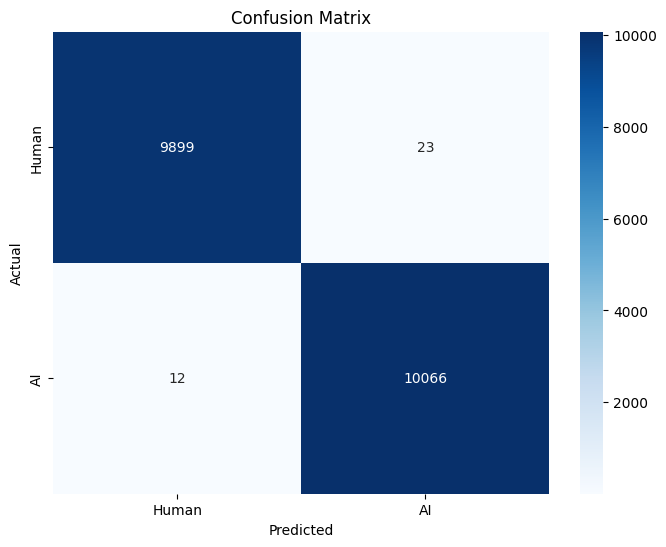

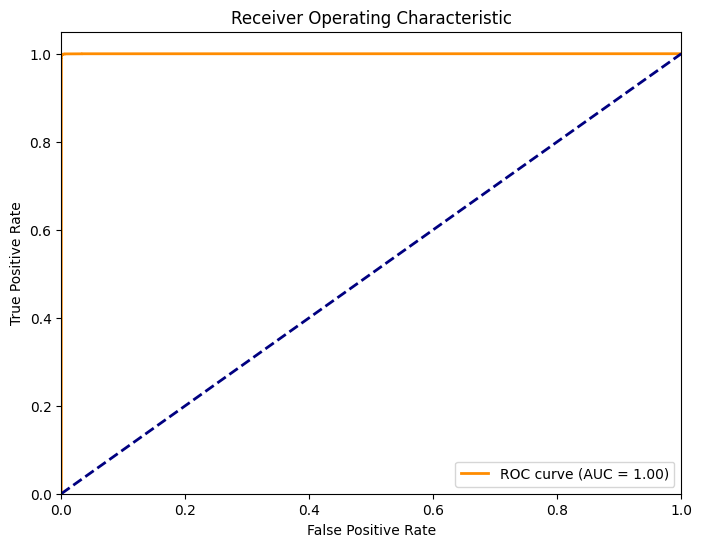


Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00      9922
          AI       1.00      1.00      1.00     10078

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Model Evaluation Metrics:
Accuracy: 0.9982
AUC: 1.0000
False Positive Rate: 0.0000
True Positive Rate: 0.0001


In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions from the trained model
print("\nGenerating predictions on test set...")
predictions = trainer.predict(test_dataset)

# Extract true labels and predicted probabilities
y_true = predictions.label_ids
y_pred_probs = predictions.predictions[:, 1]  # Probability for class 1 (AI-generated)
y_pred = np.argmax(predictions.predictions, axis=1)

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI']))

# 5. Additional Metrics
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {np.mean(y_true == y_pred):.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"False Positive Rate: {fpr[1]:.4f}")
print(f"True Positive Rate: {tpr[1]:.4f}")

🔹 Cell 17: Model and Tokenizer Loading for Inference

In this step, we load the previously saved BERT model and tokenizer to prepare for inference. This setup allows us to use the trained model to classify new text inputs as either human-written or AI-generated.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
model_path = "./bert_ai_human_classifier"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path).to("cuda")

# Set model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def predict_text(text, model, tokenizer):
    """
    Predict whether text is AI-generated (1) or human-written (0)
    Returns:
        - prediction (0 or 1)
        - confidence score (0-1)
        - class probabilities
    """
    # Clean the input text
    cleaned_text = clean_text_simple(text)

    # Tokenize and prepare input
    inputs = tokenizer(
        cleaned_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=192
    ).to("cuda")

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities
    probs = torch.softmax(outputs.logits, dim=1)
    confidence, prediction = torch.max(probs, dim=1)

    return {
        "prediction": prediction.item(),
        "confidence": confidence.item(),
        "probabilities": {
            "human": probs[0][0].item(),
            "ai": probs[0][1].item()
        }
    }

🔹 Cell 10: Sample Text Predictions

In this step, we test the trained BERT model on a set of sample texts to classify them as either human-written or AI-generated. This process demonstrates the model's inference capabilities and provides insights into its performance on various text inputs.

In [ ]:
# Sample texts to test
samples = [
    "The quick brown fox jumps over the lazy dog. This is a classic example of an English pangram.",  # Likely human
    "In accordance with meteorological predictions, the precipitation probability for the subsequent 24-hour period is approximately 67%.",  # Likely AI
    "I really enjoyed that movie last night! The acting was superb and the plot kept me engaged throughout.",  # Likely human
    "The utilization of advanced neural network architectures has facilitated significant improvements in natural language processing tasks.",  # Likely AI
    "Hey, what's up? Just wanted to check if you're coming to the party tomorrow night.",  # Likely human
    "This version should run without warnings and be more memory-efficient on Kaggle's T4 x2 GPUs. The warning about gathering scalars should no longer appear due to the proper handling of tensors in the dataset class.",
    "My account was hacked and used by someone else. After restoring it, I found that identity verification was required. When I tried to complete it through my phone, I received an error message stating that a request had already been submitted.",
    "My account got hacked and used by another one and after i restore it i found that you need identity verfication and when i do it througf my phone i see a error massege says there is a requst has been submitted",
    "My account got hacked. Then I tried to open it, but after I tried to reset my password, it said I needed to verify my account. However, when I try to verify it with my phone, it says, You have already submitted a request. Please help me get my account back.",
    "I remember the first time I tried to verify my account; my ID had expired the day before. I know it was my mistake, but I have renewed my ID and am willing to do anything to get my account back. All my projects and career achievements are on my account, and I need it. I use it for finding a job because I am currently unemployed and use my personal account to post my achievements.All I need is another chance to regain access to my account, as I rely on it for my career. I have provided everything—my ID, my phone number—and all the information matches the data on my account. Please tell me what I need to do to regain access to my account."
,
]

# Make predictions
for text in samples:
    result = predict_text(text, model, tokenizer)
    print(f"Text: {text[:60]}...")
    print(f"Prediction: {'AI-generated' if result['prediction'] else 'Human-written'}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities - Human: {result['probabilities']['human']:.2%}, AI: {result['probabilities']['ai']:.2%}")
    print("-" * 80)

Text: The quick brown fox jumps over the lazy dog. This is a class...
Prediction: AI-generated
Confidence: 99.97%
Probabilities - Human: 0.03%, AI: 99.97%
--------------------------------------------------------------------------------
Text: In accordance with meteorological predictions, the precipita...
Prediction: AI-generated
Confidence: 100.00%
Probabilities - Human: 0.00%, AI: 100.00%
--------------------------------------------------------------------------------
Text: I really enjoyed that movie last night! The acting was super...
Prediction: AI-generated
Confidence: 99.99%
Probabilities - Human: 0.01%, AI: 99.99%
--------------------------------------------------------------------------------
Text: The utilization of advanced neural network architectures has...
Prediction: AI-generated
Confidence: 100.00%
Probabilities - Human: 0.00%, AI: 100.00%
--------------------------------------------------------------------------------
Text: Hey, what's up? Just wanted to check if you're